In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RESULT_DIR = '../../results/correlation-tests/'
PREFIX_DIR = os.path.join(RESULT_DIR, 'prefix-alignment')
HMMCONF_DIR = os.path.join(RESULT_DIR, 'hmmconf.rand_init.iter_10')
PATT_DIR = os.path.join(RESULT_DIR, 'pattern')

In [3]:
prefix_df_list = []

for fname in os.listdir(PREFIX_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(PREFIX_DIR, fname)
    df = pd.read_csv(fp)
    df['log'] = fname.replace('.csv', '')
    prefix_df_list.append(df)
    
prefix_df = pd.concat(prefix_df_list)

hmm_df_list = []

for fname in os.listdir(HMMCONF_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(HMMCONF_DIR, fname)
    df = pd.read_csv(fp)
    df['log'] = df['log'].str.replace('.csv', '')
    hmm_df_list.append(df)

hmm_df = pd.concat(hmm_df_list)

patt_df_list = []

for fname in os.listdir(PATT_DIR):
    if not fname.endswith('.csv'):
        continue
    fp = os.path.join(PATT_DIR, fname)
    df = pd.read_csv(fp, sep='\t')
    df['log'] = fname.replace('.csv', '')
    patt_df_list.append(df)

patt_df = pd.concat(patt_df_list)
patt_df.rename(columns={
    'T:concept:name': 'caseid',
    'E:concept:name': 'activity'
}, inplace=True)

# create case_length
patt_df['tmp'] = 1
patt_df['case_length'] = patt_df[['caseid', 'log', 'tmp']].groupby(['log', 'caseid']).cumsum()
patt_df.drop(columns=['tmp'], inplace=True)

merged_df = pd.merge(prefix_df, patt_df, on=['log', 'caseid', 'case_length'])
merged_df = pd.merge(merged_df, hmm_df, on=['log', 'caseid', 'case_length'])

assert (merged_df['activity_x'] == merged_df['activity_y']).all()

merged_df.rename(columns={'activity_x': 'activity'}, inplace=True)
merged_df.drop(columns=['activity_y'], inplace=True)

# add model attributes
NET_DIR = '../../data/BPM2018/correlation-tests/models'
desc_fp = os.path.join(NET_DIR, 'description.csv')
desc_df = pd.read_csv(desc_fp)
get_netid = lambda s: s.replace('model_triangular_10_20_30_id_', '').replace('.pnml', '')
desc_df['net_id'] = desc_df['net'].apply(get_netid)

# add to merged_df
get_netid = lambda s: s.replace('log_model_triangular_10_20_30_id_', '').split('.pnml')[0]
merged_df['net_id'] = merged_df['log'].apply(get_netid)

merged_df = pd.merge(desc_df, merged_df, on='net_id')

### Make sure the data is consistent 

In [4]:
sort_order = ['log', 'caseid', 'case_length']
prefix_df = prefix_df.sort_values(sort_order).reset_index(drop=True)
hmm_df = hmm_df.sort_values(sort_order).reset_index(drop=True)
patt_df = patt_df.sort_values(sort_order).reset_index(drop=True)

assert prefix_df[sort_order].equals(hmm_df[sort_order])
assert patt_df[sort_order].equals(hmm_df[sort_order])

In [5]:
del hmm_df_list
del prefix_df_list
del patt_df_list

### Spearman correlation with all results

In [6]:
noisy = merged_df['cost'] > -1

filtered_df = merged_df.loc[noisy, :]
rho_conf = stats.spearmanr(filtered_df['cost'], filtered_df['final_conformance'])
rho_mean_conf = stats.spearmanr(filtered_df['cost'], filtered_df['avg_final_conformance'])
rho_exp_dist = stats.spearmanr(filtered_df['cost'], filtered_df['sum_exp_distance'])
rho_exp_comp = stats.spearmanr(filtered_df['cost'], filtered_df['exp_completeness'])
rho_mode_dist = stats.spearmanr(filtered_df['cost'], filtered_df['sum_mode_distance'])
rho_mode_comp = stats.spearmanr(filtered_df['cost'], filtered_df['mode_completeness'])

print(
    'Final conformance: {}'.format(rho_conf),
    '\nMean conformance: {}'.format(rho_mean_conf), 
    '\nSum exp distance: {}'.format(rho_exp_dist),
    '\nExp completeness: {}'.format(rho_exp_comp),
    '\nSum mode distance: {}'.format(rho_mode_dist),
    '\nMode completeness: {}'.format(rho_mode_comp)
)

Final conformance: SpearmanrResult(correlation=-0.24660264807177007, pvalue=0.0) 
Mean conformance: SpearmanrResult(correlation=-0.61663390421612574, pvalue=0.0) 
Sum exp distance: SpearmanrResult(correlation=0.52416993263323464, pvalue=0.0) 
Exp completeness: SpearmanrResult(correlation=-0.50846704236258977, pvalue=0.0) 
Sum mode distance: SpearmanrResult(correlation=0.67390971131508193, pvalue=0.0) 
Mode completeness: SpearmanrResult(correlation=-0.67561754230777482, pvalue=0.0)


### Spearman correlation with non-conforming results

In [7]:
noisy = merged_df['cost'] > 0
case_length = merged_df['case_length'] > 0
is_net = merged_df['net'] != '32'

filtered_df = merged_df.loc[noisy & case_length, :]
rho_conf = stats.spearmanr(filtered_df['cost'], filtered_df['final_conformance'])
rho_mean_conf = stats.spearmanr(filtered_df['cost'], filtered_df['avg_final_conformance'])
rho_exp_dist = stats.spearmanr(filtered_df['cost'], filtered_df['sum_exp_distance'])
rho_exp_comp = stats.spearmanr(filtered_df['cost'], filtered_df['exp_completeness'])
rho_mode_dist = stats.spearmanr(filtered_df['cost'], filtered_df['sum_mode_distance'])
rho_mode_comp = stats.spearmanr(filtered_df['cost'], filtered_df['mode_completeness'])

print(
    'Final conformance: {}'.format(rho_conf),
    '\nMean conformance: {}'.format(rho_mean_conf), 
    '\nSum exp distance: {}'.format(rho_exp_dist),
    '\nExp completeness: {}'.format(rho_exp_comp),
    '\nSum mode distance: {}'.format(rho_mode_dist),
    '\nMode completeness: {}'.format(rho_mode_comp)
)

Final conformance: SpearmanrResult(correlation=0.35477317291427624, pvalue=0.0) 
Mean conformance: SpearmanrResult(correlation=0.44898246541701675, pvalue=0.0) 
Sum exp distance: SpearmanrResult(correlation=0.69366661527621687, pvalue=0.0) 
Exp completeness: SpearmanrResult(correlation=-0.46571037667919973, pvalue=0.0) 
Sum mode distance: SpearmanrResult(correlation=0.71215517219669089, pvalue=0.0) 
Mode completeness: SpearmanrResult(correlation=-0.54818307658453647, pvalue=0.0)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


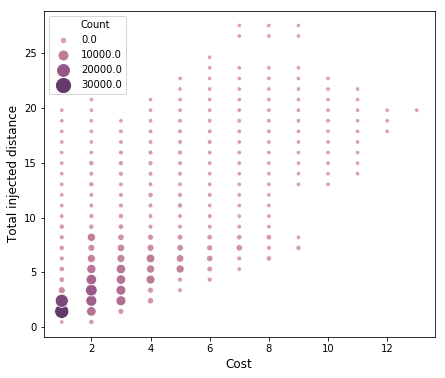

In [8]:
noisy = merged_df['cost'] > 0
case_length = merged_df['case_length'] >= 1
is_net = merged_df['net_id'] != '32'
scatter_df = merged_df.loc[noisy & case_length & is_net, :]

cost_var = 'cost'
var = 'sum_mode_distance'
_min = scatter_df[var].min()
_max = scatter_df[var].max()
bins = np.linspace(_min, _max, 30)
scatter_df['binned'] = pd.cut(scatter_df[var], bins=bins)
grouped = scatter_df[[cost_var, 'binned', 'caseid']].groupby([cost_var, 'binned'])
bubble_df = grouped.count().reset_index(drop=False)
bubble_df[var] = bubble_df['binned'].apply(lambda interval: (interval.left + interval.right) / 2)
bubble_df.rename(columns={'caseid': 'Count'}, inplace=True)

fig, ax = plt.subplots(figsize=(7, 6))
cmap = sns.cubehelix_palette(dark=.3, light=.7, as_cmap=True)

g = sns.scatterplot(x=cost_var, y=var,
               hue='Count', size='Count',
               sizes=(20, 200), palette=cmap,
               data=bubble_df, ax=ax)

_ = ax.set_xlabel('Cost', size=12)
_ = ax.set_ylabel('Total injected distance', size=12)
# _ = ax.set_title('Bubble plot of noisy non-first event instances for {}'.format(var))

outdir = './images/svg/'
if not os.path.isdir(outdir):
    os.makedirs(outdir)

out_fp = os.path.join(outdir, 'cost-injection-unconform-bubble-epsilon.svg')
fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


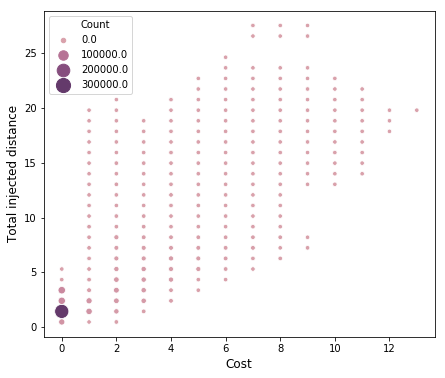

In [9]:
noisy = merged_df['cost'] > -1
case_length = merged_df['case_length'] >= 1
is_net = merged_df['net_id'] != '32'
scatter_df = merged_df.loc[noisy & case_length & is_net, :]

cost_var = 'cost'
var = 'sum_mode_distance'
_min = scatter_df[var].min()
_max = scatter_df[var].max()
bins = np.linspace(_min, _max, 30)
scatter_df['binned'] = pd.cut(scatter_df[var], bins=bins)
grouped = scatter_df[[cost_var, 'binned', 'caseid']].groupby([cost_var, 'binned'])
bubble_df = grouped.count().reset_index(drop=False)
bubble_df[var] = bubble_df['binned'].apply(lambda interval: (interval.left + interval.right) / 2)
bubble_df.rename(columns={'caseid': 'Count'}, inplace=True)

fig, ax = plt.subplots(figsize=(7, 6))
cmap = sns.cubehelix_palette(dark=.3, light=.7, as_cmap=True)

sns.scatterplot(x=cost_var, y=var,
               hue='Count', size='Count',
               sizes=(20, 200), palette=cmap,
               data=bubble_df, ax=ax)

_ = ax.set_xlabel('Cost', size=12)
_ = ax.set_ylabel('Total injected distance', size=12)
# _ = ax.set_title('Bubble plot of noisy non-first event instances for {}'.format(var))

outdir = './images/svg/'
if not os.path.isdir(outdir):
    os.makedirs(outdir)

out_fp = os.path.join(outdir, 'cost-injection-all-bubble-epsilon.svg')
fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

### Confusion matrix for fitting categorization

In [10]:
y_true = merged_df['cost'] == 0
y_pred = (merged_df['final_conformance'] > 0.99) & (merged_df['sum_mode_distance'] == 0)

from sklearn.metrics import confusion_matrix

cnf_mat = confusion_matrix(y_true, y_pred)
precision = cnf_mat[1, 1] / cnf_mat[:, 1].sum()
recall = cnf_mat[1, 1] / cnf_mat[1, :].sum()
f1 = 2 * ((precision * recall) / (precision + recall))

print('Confusion matrix: \n{}\nPrecision: {:.5f}, Recall: {:.5f}, F1: {:.5f}'.format(cnf_mat, precision, recall, f1))
print('True negatives: {}, True positives: {}, Predicted negatives: {}, Predicted positives: {}'.format(cnf_mat[0, :].sum(), cnf_mat[1, :].sum(), 
                                                                                                       cnf_mat[:, 0].sum(), cnf_mat[:, 1].sum()))


Confusion matrix: 
[[ 461533    7024]
 [ 650991 1776012]]
Precision: 0.99606, Recall: 0.73177, F1: 0.84370
True negatives: 468557, True positives: 2427003, Predicted negatives: 1112524, Predicted positives: 1783036
